File path: /Users/yutanzhang/Desktop/SST/HadISST_sst.nc

In [ ]:
import netCDF4 as nc
import numpy as np

# Access file
file_path = '/Users/yutanzhang/Desktop/SST/HadISST_sst.nc'

# Open NetCDF
dataset = nc.Dataset(file_path, mode='r')

# Print basic file information
print("File format:", dataset.file_format)
print("Dimensions:")
for dim in dataset.dimensions.values():
    print(f"  {dim.name}: {len(dim)}")

print("\nVariables:")
for var_name, var in dataset.variables.items():
    print(f"  {var_name}: {var.dimensions} -> {var.dtype}")

# Close file
dataset.close()

File format: NETCDF3_CLASSIC
Dimensions:
  time: 1864
  latitude: 180
  longitude: 360
  nv: 2

Variables:
  time: ('time',) -> float32
  time_bnds: ('time', 'nv') -> float32
  latitude: ('latitude',) -> float32
  longitude: ('longitude',) -> float32
  sst: ('time', 'latitude', 'longitude') -> float32


In [14]:
import netCDF4 as nc
import numpy as np

ds = nc.Dataset('/Users/yutanzhang/Desktop/SST/HadISST_sst.nc')
time_var = ds.variables['time']

# Check metadata
print("Time units:", time_var.units)
print("Calendar:", getattr(time_var, 'calendar', 'standard'))

# Convert to actual dates
time_values = nc.num2date(time_var[:], units=time_var.units, calendar=getattr(time_var, 'calendar', 'standard'))
print("Start date:", time_values[0])
print("End date:", time_values[-1])

ds.close()

Time units: days since 1870-1-1 0:0:0
Calendar: gregorian
Start date: 1870-01-16 11:59:59.505615
End date: 2025-04-16 00:00:00


Plot global average sst per month

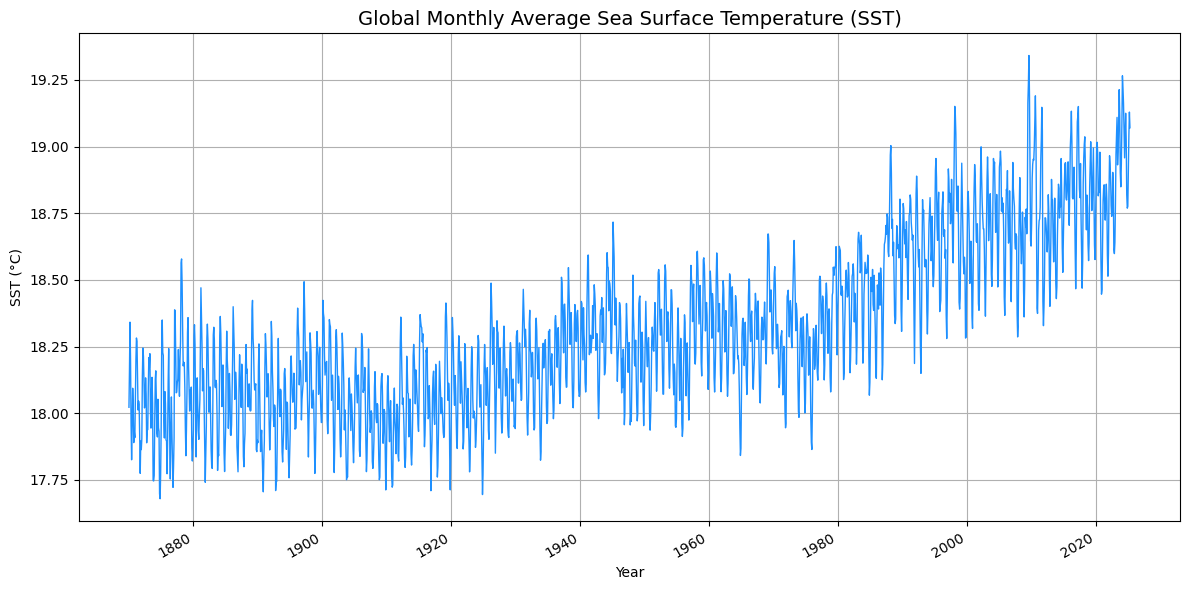

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

file_path = '/Users/yutanzhang/Desktop/SST/HadISST_sst.nc'
ds = nc.Dataset(file_path)

sst_raw = ds.variables['sst'][:]
lat = ds.variables['latitude'][:]
lon = ds.variables['longitude'][:]
time = ds.variables['time']
time_units = time.units
calendar = getattr(time, 'calendar', 'standard')

dates_raw = nc.num2date(time[:], units=time_units, calendar=calendar)
dates = np.array([datetime(d.year, d.month, d.day) for d in dates_raw])

fill_value = getattr(ds.variables['sst'], '_FillValue', 1e20)
sst = np.ma.masked_where((sst_raw == fill_value) | (sst_raw > 1e10) | (sst_raw < -10), sst_raw)

deg_to_rad = np.pi / 180.0
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
lat_abs = np.abs(lat_grid)
weights = (np.sin((lat_abs + 0.5) * deg_to_rad) - np.sin((lat_abs - 0.5) * deg_to_rad)) / 720

global_sst = np.empty(sst.shape[0])
for t in range(sst.shape[0]):
    sst_t = sst[t, :, :]
    w_t = np.ma.array(weights, mask=sst_t.mask)
    if np.sum(~w_t.mask) < 10:  # not enough ocean points
        global_sst[t] = np.nan
    else:
        w_t /= np.sum(w_t)
        global_sst[t] = np.ma.average(sst_t, weights=w_t)

valid = ~np.isnan(global_sst)
dates_valid = dates[valid]
global_sst_valid = global_sst[valid]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates_valid, global_sst_valid, color='dodgerblue', linewidth=1)
ax.set_title('Global Monthly Average Sea Surface Temperature (SST)', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('SST (°C)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
ax.grid(True)
plt.tight_layout()
plt.show()

ds.close()